# Examples of using HTOF:
### This notebook contains a variety of use case examples for htof.

## Example 1: Combining astrometric missions for beta pic and extracting the best fit astrometric parameters from the two

In [1]:

from htof.parse import GaiaData, GaiaeDR3, HipparcosOriginalData, DataParser
from htof.fit import AstrometricFitter
from htof.sky_path import parallactic_motion, earth_ephemeris
from astropy import time
from astropy.time import Time
from astropy.coordinates import Angle
from astropy.constants import G
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.image import NonUniformImage, AxesImage
import astropy.units as u
from scipy.interpolate import interp1d
from scipy import ndimage

# lets combine the astrometric missions of gaia EDR3 and hipparcos 1. Note that, in detail, this is incorrect since the scans
# are not in the same reference frame. But this illustrates HTOF's functionality.

# relevant star parameters
hip_id = '27321'
cntr_ra, cntr_dec = Angle(86.82118072, 'degree'), Angle(-51.06671341, 'degree')
plx = 1.1 * u.mas # fake parallax
# parse Hipparcos 1 data for hip 27321
hip1 = HipparcosOriginalData()
hip1.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/Hip1/IntermediateData')
hip1.calculate_inverse_covariance_matrices()

# parse Gaia EDR3.
gaia = GaiaeDR3()
gaia_err = 120/1000  # gaia single measurement error in milli arc second. Should be ~50 to 170 micro arc seconds.
gaia.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/GaiaeDR3')
gaia.along_scan_errs = pd.Series(np.ones(len(gaia), dtype=float) * gaia_err)
gaia.calculate_inverse_covariance_matrices()

# combine the two missions:
data = hip1 + gaia # combined mission data

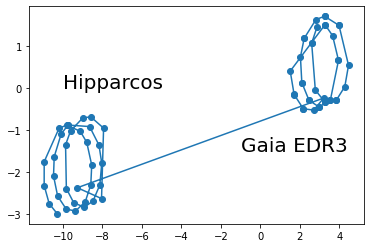

best fit astometric parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:
(mas, mas, mas, mas/yr, mas/yr)
[ 1.1 -0.  -0.   0.5  0.1]
standard errors on the five parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:
[0.02888 0.1017  0.10572 0.01636 0.01683]
formal chisquared of the fit (will be near 0 because there is no noise):
1.4081286697388012e-11


In [6]:
# get the epochs for the fit
epochs = data.julian_day_epoch()

# generate the parallactic perturbations. For simplicity, assume ngrst and gaia and hipparcos are all in orbit
# around earth (even though Gaia is at L2). Really we would want to hstack the parallactic perturbations for each
# different ephemeris.
jyear_epoch = time.Time(epochs, format='jd', scale='tcb').jyear
# pick a central epoch for the fit:
central_epoch = 2010
ra_motion, dec_motion = parallactic_motion(jyear_epoch, cntr_ra.degree, cntr_dec.degree, 'degree',
                                           time.Time(central_epoch, format='decimalyear', scale='tcb').jyear,
                                           ephemeris=earth_ephemeris)
# ra_motion, dec_motion are the parallax motion alone, for a parallax of 1 mas.
# note that ra_motion and dec_motion are in degrees here.
# generate sky path
year_epochs = jyear_epoch - time.Time(central_epoch, format='jyear', scale='tcb').jyear
# add a small linear motion (fake proper motion of beta pic) of 5 mas/yr in ra and .1 mas/yr in dec
ra = Angle(.5 * year_epochs, unit='mas') + Angle(ra_motion, unit='degree') * plx.value
dec = Angle(.1 * year_epochs, unit='mas') + Angle(dec_motion, unit='degree') * plx.value

# for large proper motions, ideally you will want to fit iteratively, because there are small numerical round offs
# that add up.

plt.figure()
plt.scatter(ra, dec)
plt.annotate('Hipparcos', xy=(-10, 0), fontsize=20)
plt.annotate('Gaia EDR3', xy=(-1, -1.5), fontsize=20)
plt.plot(ra, dec)
plt.show()

# now we fit with htof.fitter to solve for the proper motions (which will be equal to the input proper motions)
# fit_degree = 1 gives a standard 4 parameter fit (position + proper motions), or a 5 parameter fit (parallax, positions, proper motions) if 
# use_parallax=True and the parallactic components are given.
fitter = AstrometricFitter(data.inverse_covariance_matrix, jyear_epoch,
                           use_parallax=True, fit_degree=1, central_epoch_ra=central_epoch, 
                           central_epoch_dec=central_epoch,
                           parallactic_pertubations={'ra_plx': Angle(ra_motion, 'degree').mas,
                                                     'dec_plx': Angle(dec_motion, 'degree').mas})
# fit the standard model
astrometric_parameters, errors, chisquared = fitter.fit_line(ra.mas, dec.mas, return_all=True)
print('best fit astometric parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:')
print('(mas, mas, mas, mas/yr, mas/yr)')
print(astrometric_parameters.round(3))
print('standard errors on the five parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:')
print(errors.round(5))
print('formal chisquared of the fit (will be near 0 because there is no noise):')
print(chisquared)

#### Lets also compute a variety of interesting parameters concerning this combined astrometric mission:

The covariance matrix of the five astrometric parameters:

In [7]:
covmat = fitter.evaluate_cov_matrix(central_epoch, central_epoch)
print(covmat)
print('note that the sqrt of the diagonal of the covariance matrix is equal to the standard errors on the parameters from the previous fit (as it should)')
print(list(np.sqrt(np.diagonal(covmat)).round(5)))
print('standard errors on the five parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:')
print(errors.round(5))

[[ 8.34342863e-04 -5.58154324e-05  9.42265984e-05  2.01458530e-05
  -1.56400881e-05]
 [-5.58154324e-05  1.03438425e-02 -7.24140630e-04 -1.60236178e-03
   1.30613912e-04]
 [ 9.42265984e-05 -7.24140630e-04  1.11757135e-02  1.32448660e-04
  -1.71595818e-03]
 [ 2.01458530e-05 -1.60236178e-03  1.32448660e-04  2.67716832e-04
  -2.54324591e-05]
 [-1.56400881e-05  1.30613912e-04 -1.71595818e-03 -2.54324591e-05
   2.83135999e-04]]
note that the sqrt of the diagonal of the covariance matrix is equal to the standard errors on the parameters from the previous fit (as it should)
[0.02888, 0.1017, 0.10572, 0.01636, 0.01683]
standard errors on the five parameters: [parallax, ra, dec, proper motion ra, proper motion dec]:
[0.02888 0.1017  0.10572 0.01636 0.01683]


The epochs at which the covariance between ra/pm_ra and dec/pm_dec (position/proper motion) is zero. These are called the central epochs.

In [8]:
best_epoch_ra, best_epoch_dec = fitter.find_optimal_central_epoch(coordinate='ra'), fitter.find_optimal_central_epoch(coordinate='dec')
print(best_epoch_ra, best_epoch_dec)

2015.9852858659249 2016.060543990744


Now lets check by computing the covariance matrix with those ra and dec epochs, comparing it to the one we computed above with a central epoch of 2010 for both ra and dec.

In [9]:
covmatbest = fitter.evaluate_cov_matrix(best_epoch_ra, best_epoch_dec)  # we set the central epoch above to be 2010, and centered the times around it, so we want 0,0 here.
print(f'ra/pm_ra covariance at the central epoch {best_epoch_ra : 1f}:')
print(covmatbest[1, 3].round(11)) # rounding to the eleventh decimal
print('ra/pm_ra covariance at 2010:')
print(covmat[1, 3].round(11))

print(f'dec/pm_dec covariance at the central epoch {best_epoch_dec: 1f}:')
print(covmatbest[2, 4].round(11)) # rounding to the eleventh decimal
print('dec/pm_dec covariance at 2010:')
print(covmat[2, 4].round(11))

ra/pm_ra covariance at the central epoch  2015.985286:
0.0
ra/pm_ra covariance at 2010:
-0.00160236178
dec/pm_dec covariance at the central epoch  2016.060544:
0.0
dec/pm_dec covariance at 2010:
-0.00171595818


## Example 2: Identifying the bugged epochs that should be removed for a Hip2 source (using the Java tool IAD)

In [6]:
# here we are going to just parse an hip2.1 (java tool iad) source. Parsing will automatically identify any epochs that need to be rejected because of the write out bug.
# This does not work for every source, but it does for the vast majority (of java tool and hip1 sources).
# an up to date list of the sources, for which this does not work, can be found in htof/data. 
# e.g. htof/data/hip1_flagged.txt, htof/data/hip2_dvd_flagged.txt, htof/data/hip2_Javatool_flagged.txt
import os
from htof.parse import HipparcosRereductionJavaTool

test_data_directory = os.path.join(os.getcwd(), 'htof/test/data_for_tests/Hip21')
data = HipparcosRereductionJavaTool()
# get info on the IAD without doing any rejection:

iad_with_header, iad = data.parse(star_id=44050, intermediate_data_directory=test_data_directory, attempt_adhoc_rejection=True)
print('Although data is fixed, the IAD that are returned by data parser are untouched. Note that the last 3 along scan errors (last column) are repeated')
print(iad)
print('length of the iad:', len(iad))
print('last ten along scan errors from the uncorrected IAD:')
print(iad[6][-10:])

print('now lets look at the DataParser object, which is actually fixed.')
print('length of the fixed data:', len(data))
print('So the fixed data have 71 transits instead of 74, because the 3 bugged epochs have been removed, and orbits have been shuffled.')

Although data is fixed, the IAD that are returned by data parser are untouched. Note that the last 3 along scan errors (last column) are repeated
       0       1       2       3       4     5     6
0    310 -1.0292  0.1738 -0.0457  0.9990  2.56  2.71
1    310 -1.0292  0.1683 -0.0381  0.9993  0.15  2.62
2    310 -1.0292  0.1686 -0.0391  0.9992  3.04  2.49
3    311 -1.0281  0.1627 -0.0279  0.9996 -0.12  2.50
4    311 -1.0281  0.1582 -0.0216  0.9998 -4.89  3.22
..   ...     ...     ...     ...     ...   ...   ...
69  2014  1.0412 -0.6202  0.8170  0.5766 -4.13  4.76
70  2079  1.1201  0.6583 -0.4111  0.9116  3.38  3.19
71  2079  1.1201  0.6586 -0.4115  0.9114  3.29  4.74
72  2079  1.1201  0.6592 -0.4122  0.9111 -4.07  4.76
73  2079  1.1201  0.6590 -0.4120  0.9112  3.44  3.19

[74 rows x 7 columns]
length of the iad: 74
last ten along scan errors from the uncorrected IAD:
64    1.85
65    2.02
66    2.17
67    3.80
68    4.74
69    4.76
70    3.19
71    4.74
72    4.76
73    3.19
Name: 6, d

if you wanted to fix the IAD yourself (and not use htof any further), you would first parse the source with htof. Then call data.additional_rejected_epochs to tell which epochs should be removed from the IAD.

In [7]:
data.additional_rejected_epochs

{'residual/along_scan_error': [73, 72, 71],
 'orbit/scan_angle/time': [9, 10, 44]}

You would remove the scan angles/orbits/ times from transits 9, 10 and 44, then slide up the orbits to fit. Note again, that htof does all of this automatically on .parse(). Then you would remove the last 3 residuals (again because there are 3 bugged epochs for this source): 73, 72, 71

htof does this correction automatically, but will not save a new intermediate data file. Although, you can write out a file of scan angles, times, along scan errors, and residuals (that would be automatically fixed):

In [8]:
test_data_directory = os.path.join(os.getcwd(), 'htof/test/data_for_tests/Hip21')
data = HipparcosRereductionJavaTool()
# get info on the IAD without doing any rejection:

data.parse(star_id=44050, intermediate_data_directory=test_data_directory, attempt_adhoc_rejection=True)
data.write('fixed_iad_44050.csv', overwrite=True)
print('note that the last column (icov) of this .csv file will just be zeros, because we did not call data.calculate_inverse_covariance_matrices()')

note that the last column (icov) of this .csv file will just be zeros, because we did not call data.calculate_inverse_covariance_matrices()


## Example 3: Here we combine some of the above examples to make a figure very similar to Figure 6 from the HTOF paper. 

In [9]:
"""
Preliminaries
"""

# relevant star parameters
hip_id = '27321'
cntr_ra, cntr_dec = Angle(86.82118072, 'degree'), Angle(-51.06671341, 'degree')
plx = 51.44 * u.mas
mass_star = 1.84 * u.solMass
########

def calc_orbit(varpi, a, inc, Ma, phase, time, multiplier=1):
    """
    :param varpi: parallax angle (units attached)
    :param a: semi major axis (units attached)
    :param inc: inclination in radians or with unit attached
    :param Ma: mass of the primary (units attached)
    :param phase: phase of the orbit in radians or with unit attached
    :param time: time to evaluate the orbit (units attached), i.e. time.Time(times, format='jd')
    :param multiplier: optional multiplier, e.g. -Mb/Ma to calculate the pertubation on the host star.
    :return: motion: dict
            motion['ra'], motion['dec'] gives the orbit in the plane of the sky with the same units as
            the parallax angle varpi.
    """
    # calculate the orbit of the secondary in the center of momentum frame.
    # multiply results by -Mb/Ma (b is planet) to get to delta RA and delta Dec for the star.
    period = np.sqrt(4*(np.pi**2)*(a)**3 / (G*Ma))
    phases = ((2*np.pi)/period.to(u.second) * time.to(u.second)).value * u.rad
    amplitude = (((varpi.to(u.arcsec)).value * (a.to(u.pc)).value) * u.rad).to(varpi.unit)
    # TODO do I need a cosine delta term here?
    return {'dec': multiplier * amplitude * np.cos(inc)*np.cos(phases + phase),
            'ra': multiplier * amplitude * np.sin(phases + phase)}

In [10]:
# User parameters:
gaia_err = 120/1000  # gaia single measurement error in milli arc second. Should be ~50 to 170 micro arc seconds.
ngrst_err = 10/1000  # single measurement error for the other mission in milli arc second
central_epoch = 2020
num_phases = 8  # number of orbital phases to averaged over
num_inclinations = 4  # number of orbital inclinations to average over

num = 6  # number of measurements for the new NGRST mission
add_gaia = True  # whether to add gaia data (i.e. a merger of Hipparcos and Gaia)
add_ngrst = True  # whether to add NGRST data (i.e. a merger of Hipparcos and Gaia and NGRST)
add_hip = True


check_orbit = False  # debug

#############


In [11]:

# define the epochs for the NGRST mission
other_epochs = Time(np.random.uniform(2025, 2030, num), format='jyear')  # measurement epochs for the other mission.
separations = np.logspace(-1, np.log10(40), 100) * u.AU


# make data parser object for NGRST
icovar = np.linalg.pinv(np.array([[ngrst_err**2, 0], [0, ngrst_err**2]]) * np.ones((num, 2, 2)))
ngrst = DataParser(epoch=pd.DataFrame(other_epochs.jd), inverse_covariance_matrix=icovar)

# parse Hipparcos 1 data for hip 27321
hip1 = HipparcosOriginalData()
hip1.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/Hip1/IntermediateData')
hip1.calculate_inverse_covariance_matrices()

# parse Gaia full data release data (projected)
gaia = GaiaData()
gaia.parse(star_id=hip_id, intermediate_data_directory='htof/test/data_for_tests/GaiaDR2')
gaia.along_scan_errs = pd.Series(np.ones(len(gaia), dtype=float) * gaia_err)
gaia.calculate_inverse_covariance_matrices()

data = DataParser()

# merge the intermediate data together
plot_title = ''
if add_hip:
    data += hip1
    plot_title += 'Hip1 + '
if add_gaia:
    data += gaia
    plot_title += 'Gaia DR4 + '
if add_ngrst:
    data += ngrst
    plot_title += 'NGRST'
    

# for debug only:
if check_orbit:
    motion = calc_orbit(51*u.mas, 2.8*u.AU, 0*u.degree, 1.8*u.solMass,
                        0*u.degree, np.linspace(0, .9, 100)*u.year,
                        multiplier=(8*u.jupiterMass/(1.8*u.solMass)).decompose())
    plt.figure()
    plt.plot(motion['ra'], motion['dec'])
    plt.xlabel('{0}'.format(motion['ra'].unit))
    plt.ylabel('{0}'.format(motion['dec'].unit))
    plt.tight_layout()
    plt.show()

    
# get the epochs for the fit
epochs = data.julian_day_epoch()

# generate the parallactic perturbations. For simplicity, assume ngrst and gaia and hipparcos are all in orbit
# around earth (even though Gaia is at L2). Really we would want to hstack the parallactic perturbations for each
# different ephemeris.
jyear_epoch = time.Time(epochs, format='jd', scale='tcb').jyear
ra_motion, dec_motion = parallactic_motion(jyear_epoch, cntr_ra.degree, cntr_dec.degree, 'degree',
                                           time.Time(central_epoch, format='decimalyear', scale='tcb').jyear,
                                           ephemeris=earth_ephemeris)
# note that ra_motion and dec_motion are in degrees here.
# generate sky path
year_epochs = jyear_epoch - time.Time(central_epoch, format='jyear', scale='tcb').jyear
# to avoid numerical issues: set the observed motion to zero. this just assumes you have somehow accounted
# for the linear motion and parallax perfectly, and now you want to use HTOF to fit for the remainder.
ra = Angle(0 * year_epochs, unit='degree')
dec = Angle(0 * year_epochs, unit='degree')

# instantiate fitter
fitter = AstrometricFitter(data.inverse_covariance_matrix, year_epochs,
                           use_parallax=True, fit_degree=1,
                           parallactic_pertubations={'ra_plx': Angle(ra_motion, 'degree').mas,
                                                     'dec_plx': Angle(dec_motion, 'degree').mas})


# define a function to calcluate the chisquared of the fit
def calc_chisqds(separations, plx, inc, mass_star, phase, epochs, fitter):
    chisqds = []
    for separation in separations:
        motion = calc_orbit(plx, separation, inc,
                            mass_star, phase, epochs)
        coeffs, errs, chisq = fitter.fit_line((ra + motion['ra']).mas,
                                              (dec + motion['dec']).mas, return_all=True)
        chisqds.append(chisq)
    return np.array(chisqds)


phases = np.linspace(0, 2*np.pi, num_phases) * u.rad
inclinations = np.arcsin(np.linspace(0, 1, num_inclinations)) * u.rad #7
if num_inclinations == 1:
    inclinations = np.array([np.pi/2]) * u.rad

all_chisqds = []
for inc in inclinations:
    for phase in phases:
        all_chisqds.append(calc_chisqds(separations, plx, inc, mass_star, phase,
                                        year_epochs*u.year, fitter))

chisqds = np.average(all_chisqds, axis=0)

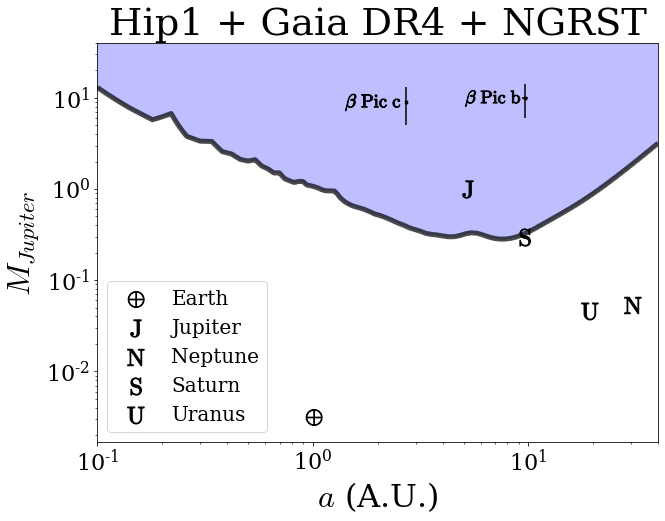

In [12]:
"""
Now we will use the calculated chisquareds to make a 2d contour plot of the data.
"""

###################
title_font_size = 28
tick_font_size = 32
######
# setting plot parameters
font = {'family' : 'serif',
        'size'   : tick_font_size}
plt.rc('font', **font)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('mathtext', fontset="cm") # fixing latex fonts
#######

def resample(x, y, num):
    f = interp1d(x, y, kind='linear')
    x_lin = np.linspace(np.min(x), np.max(x), num)
    return x_lin, f(x_lin)

separation_samples = 1000
mass_samples = 1000


fig, ax = plt.subplots(figsize=(10, 8))


# use the chisquareds and separations 
separations, chisqds = resample(separations, chisqds, separation_samples) # resample onto log grid
masses = np.linspace(1/600, 40, mass_samples) * u.M_jup

# generate chisquared array for all the masses
chisqds = np.ones((len(masses), len(separations)), dtype=float) * np.array(chisqds)
# apply the scaling with the astrometric signal (saves having to calculate the fit over the masses).
# This is why we do not calculate chisquared changes in the mass in the previous Cell of this notebook).
chisqds *= (((-masses / mass_star).decompose().value).reshape(-1, 1)) ** 2
masses = masses.value
# plotting contours
sigma_contour = np.sqrt(30)
X, Y = np.meshgrid(separations.flatten(), masses.flatten())
cs1 = ax.contour(X, Y, np.sqrt(chisqds), [sigma_contour], colors='black',
linestyles=['solid'], linewidths=5, alpha=0.7)
cs2 = ax.contourf(X, Y, np.sqrt(chisqds), [0, sigma_contour, 10000], extend='both',
                  colors=['w', 'b'], alpha=0.25)
cs2.cmap.set_under('w')
cs2.cmap.set_over('b')
ax.set_title(plot_title)
#ax.clabel(contours, inline=True, fontsize=20, fmt='%1.1f', manual=[(3, 1)], inline_spacing=0)

# plotting planets
solar_system = [{'mass': 1 / 317.8, 'a': 1, 'name': 'Earth', 'marker': r'$\oplus$'},
                {'mass': 1, 'a': 5.2, 'name': 'Jupiter', 'marker': r'${\rm J}$'},
                {'mass': 17.15 / 317.8, 'a': 30.11, 'name': 'Neptune', 'marker': r'${\rm N}$'},
                {'mass': 95.16 / 317.8, 'a': 9.55, 'name': 'Saturn', 'marker': r'${\rm S}$'},
                {'mass': 14.54 / 317.8, 'a': 19.2, 'name': 'Uranus', 'marker': r'${\rm U}$'}]
betapic = [{'mass': 10, 'a': 9.65, 'name': r'$\beta~{\rm Pic~b}$', 'marker': r'$\beta~{\rm Pic~b}$',
            'merr': 4, 'aerr': .3},
           {'mass': 9, 'a': 2.7, 'name': r'$\beta~{\rm Pic~c}$', 'marker': r'$\beta~{\rm Pic~c}$',
            'merr': 4, 'aerr': 0.02},
           ]

for planet in solar_system:
    ax.scatter(planet['a'], planet['mass'], marker=planet['marker'], color='k', label=planet['name'],
               s=300, zorder=9)

ax.legend(loc='lower left', prop={'size': 20})

for planet in betapic:
    ax.scatter(planet['a']*0.7, planet['mass'], marker=planet['marker'],
               color='k', label=planet['name'],
               s=3000, zorder=9)
    ax.scatter(planet['a'], planet['mass'], marker='x', color='k', s=10, zorder=9)
    ax.errorbar(planet['a'], planet['mass'],
                yerr=planet['merr'], xerr=planet['aerr'], zorder=9, color='k')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'$M_{Jupiter}$')
ax.set_xlabel(r'$a$ (A.U.)')

plt.tight_layout()
plt.show()
